In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
! pip install -q gwpy
! pip install -q lalsuite pycbc

In [ ]:
from gwosc.datasets import event_gps
from gwpy.time import to_gps
from gwpy.time import from_gps
from pycbc.waveform import get_td_waveform
from gwpy.timeseries import TimeSeries
from pycbc.types import timeseries
from pycbc.detector import Detector

/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [ ]:
gps = event_gps('GW200129')
print('Time of the event',gps)

Time of the event 1264316116.4


In [ ]:
print(from_gps(gps))

2020-01-29 06:54:58.400000


In [ ]:
segment = (int(gps)-16, int(gps)+16)
print(segment)

(1264316100, 1264316132)


In [ ]:
duration_of_data=segment[1]-segment[0]
print(duration_of_data)

32


In [ ]:
time_center=gps

In [ ]:
data={} # an empty dictionary
ifos=['L1','H1','V1'] # a list which we use as the dictionary keys
for ifo in ifos:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_center - 512, time_center + 512)
    data[ifo]=data[ifo].resample(2048)

/usr/local/lib/python3.10/dist-packages/gwpy/plot/axes.py:190: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


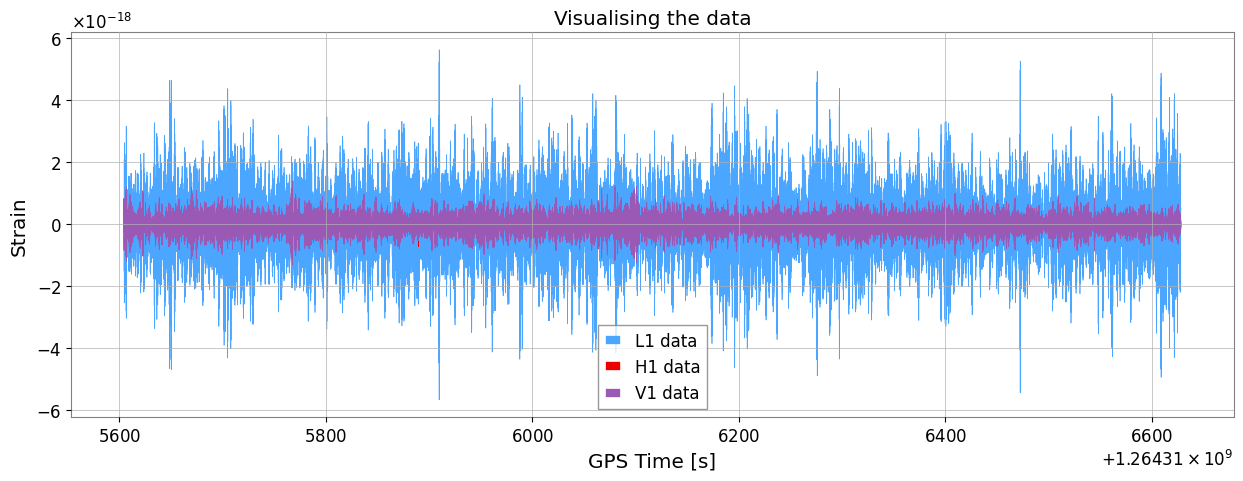

In [ ]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford','gwpy:virgo']


for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour, linewidth=0.5)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Visualising the data')
plt.legend();

Above, I have downloaded event data that is 1024 seconds long. This gives me a chance to normalise over all the noise including transient noise if any when whitening the data.

Below, I have plotted a Qtransform of the data to visualise where the signal is evident. As we can see it is visible between the range of 30 Hz to 100 Hz. Also, the same signal is evident in all of the other detectors as well, except the Virgo detector which has a lower sensitivity.

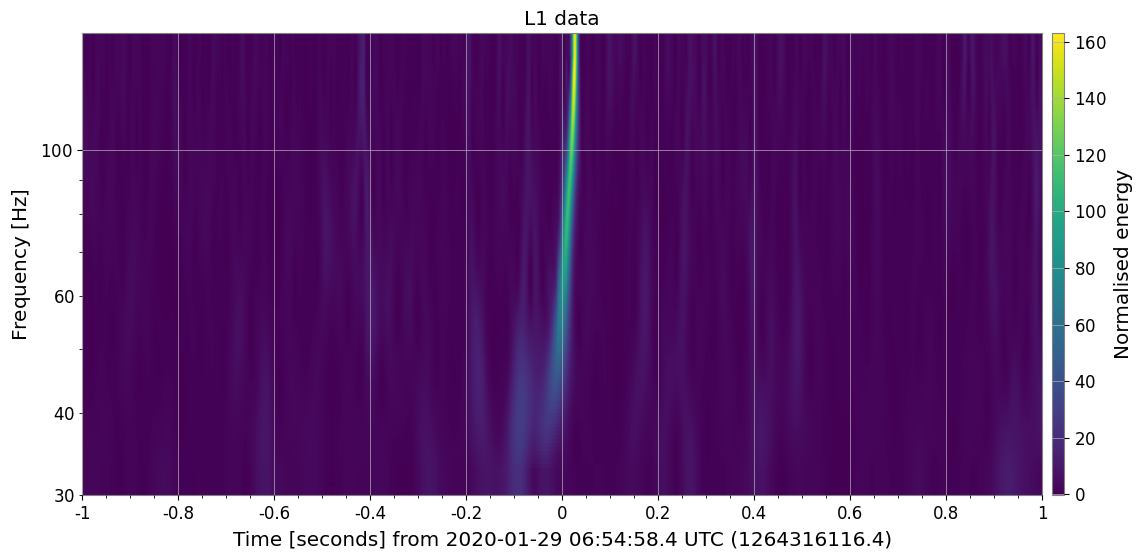

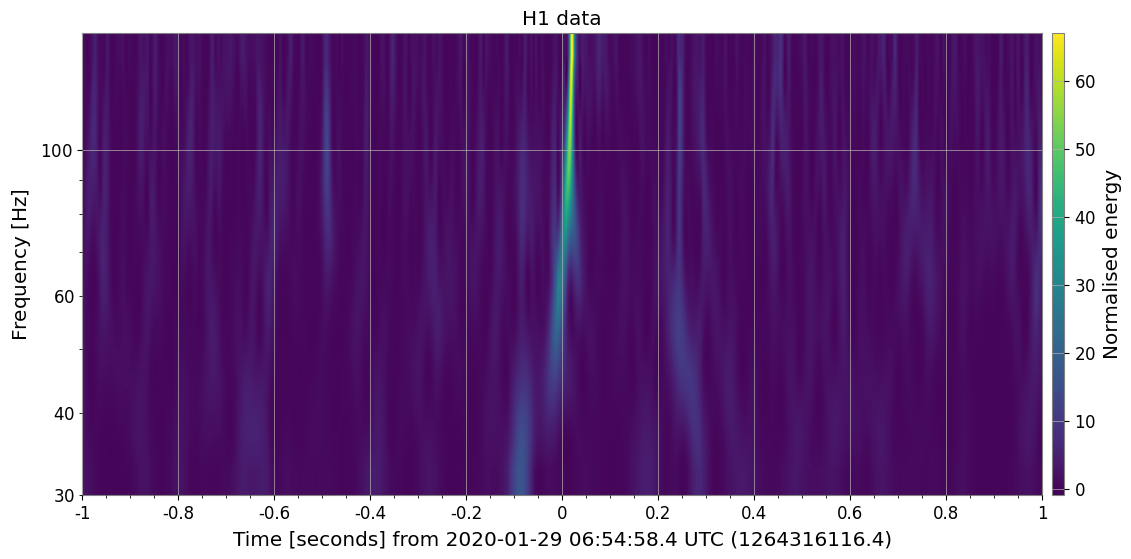

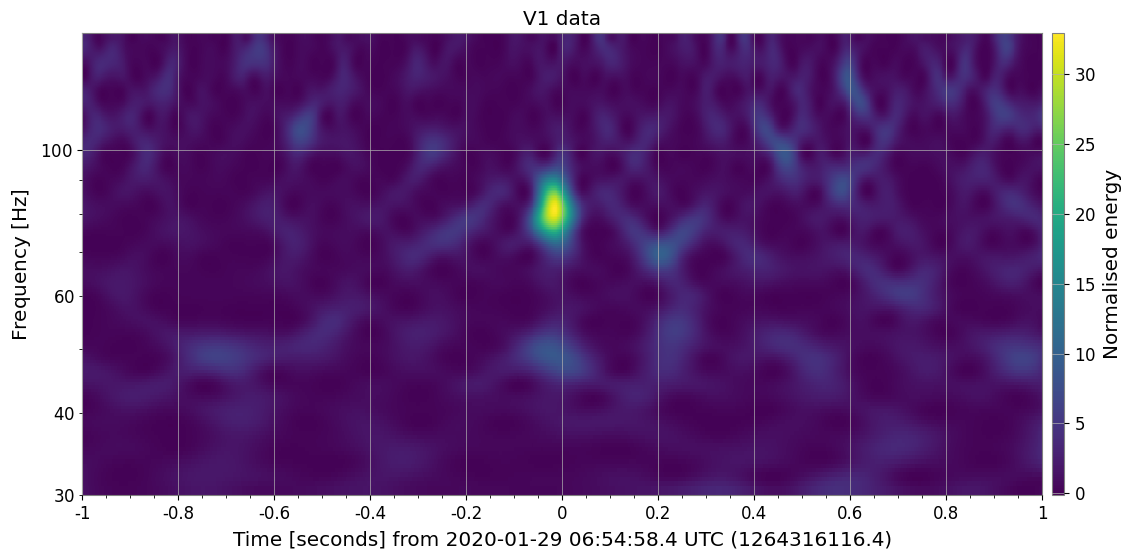

In [ ]:
hq={}
for ifo,colour in zip(ifos,colours):
  hq[ifo] = data[ifo].q_transform(frange=(30, 150),outseg=(time_center - 1, time_center + 1))
  plot=hq[ifo].plot()
  ax = plot.gca()
  ax.set_epoch(gps)
  ax.set_yscale('log')
  ax.colorbar(label="Normalised energy")
  ax.set_title('{} data'.format(ifo))

Calculating the Power Spectral Density (PSD) of the data to chack all the frequency range and what frequencies are strong.

In [ ]:
psd_full={}
for ifo in ifos:
    psd_full[ifo] = data[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)


I have cropped and editted data throught this notebook to fit my convenience. Below, I have cropped the original data to 32 seconds, resampled it and taken a PSD of it.

The fft length is 4 with an overlap of 2 which ensures that each part of the data is coverd when fft is calculated over length of 4. Windowing function smooths down the edges, just to makes sure there are no artefacts generated during the calculation of fft in chunks. 1/4 is the length of the edge that is being windowed.

In [ ]:
data_32={}
psd_32={}
for ifo in ifos:
  data_32[ifo]=data[ifo].resample(2048).crop(gps-16, gps+16)
  psd_32[ifo]=data_32[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

/usr/local/lib/python3.10/dist-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (2048.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


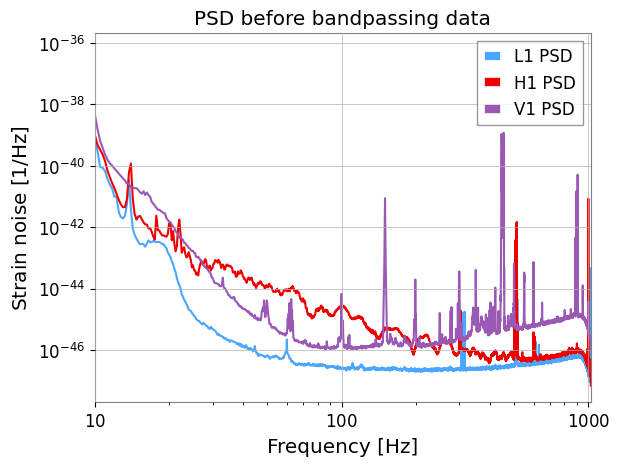

In [ ]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd_full[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD before bandpassing data')
plt.xlim(10,1024)
plt.legend();

Clearly there are lot of noise in the signal. More easier way to look at the data will be to whiten it and bandpass it which I do in the next section.

###Whitenening the data

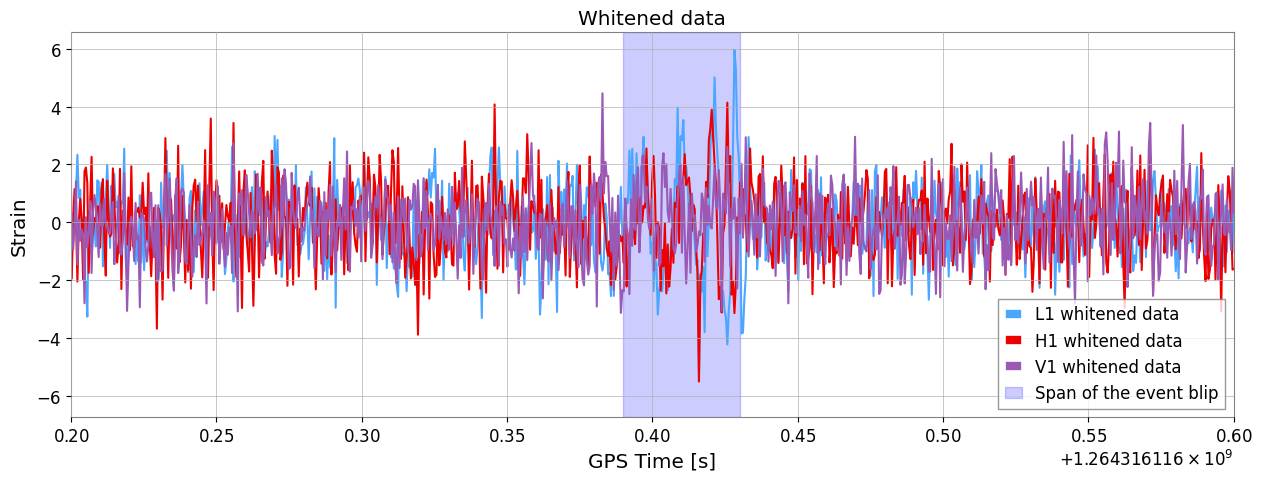

In [ ]:
plt.figure(figsize=(15,5))

white_data = {}
whitened_data = {}
for ifo, colour in zip(ifos, colours):
    whitened_data[ifo] = data[ifo].whiten(fftlength=4)
    white_data[ifo] = whitened_data[ifo].crop(gps - 16, gps + 16)
    plt.plot(white_data[ifo], label='{} whitened data'.format(ifo), color=colour)

plt.xlim(time_center - 0.2, time_center + 0.2)
plt.axvspan(gps - 0.01, gps + 0.03, alpha=0.2, color='b', label='Span of the event blip')
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Whitened data')
plt.legend()
plt.show()

In [ ]:
print(white_data['H1'].duration)

32.0 s


Whitened data is normalised acroos the noise which gives a flat PSD like seen below.

In [ ]:
psd1={}
for ifo in ifos:
    psd1[ifo] = white_data[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

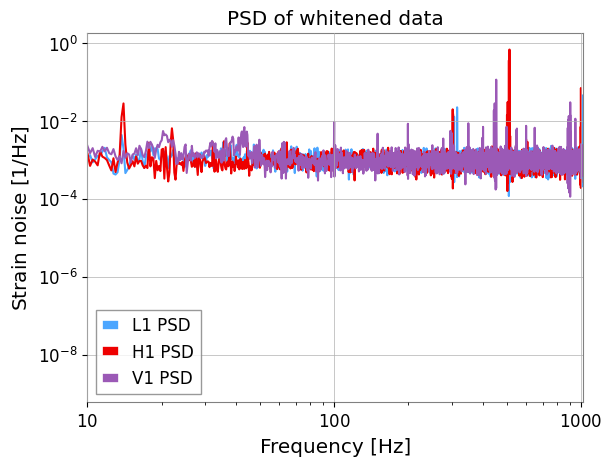

In [ ]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd1[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD of whitened data')
plt.xlim(10,1024)
plt.legend();

###Bandpassing and resampling the whitened data

In [ ]:
data_filt={}
# Remove the low and high frequency content
for ifo in ifos:
    data_filt[ifo] = white_data[ifo].bandpass(30,120)

Bandpassing the data removes all the frequencies above and belowe the specified frequency range which take sout all the uneccessary processing and frequencies that does not hold any data.

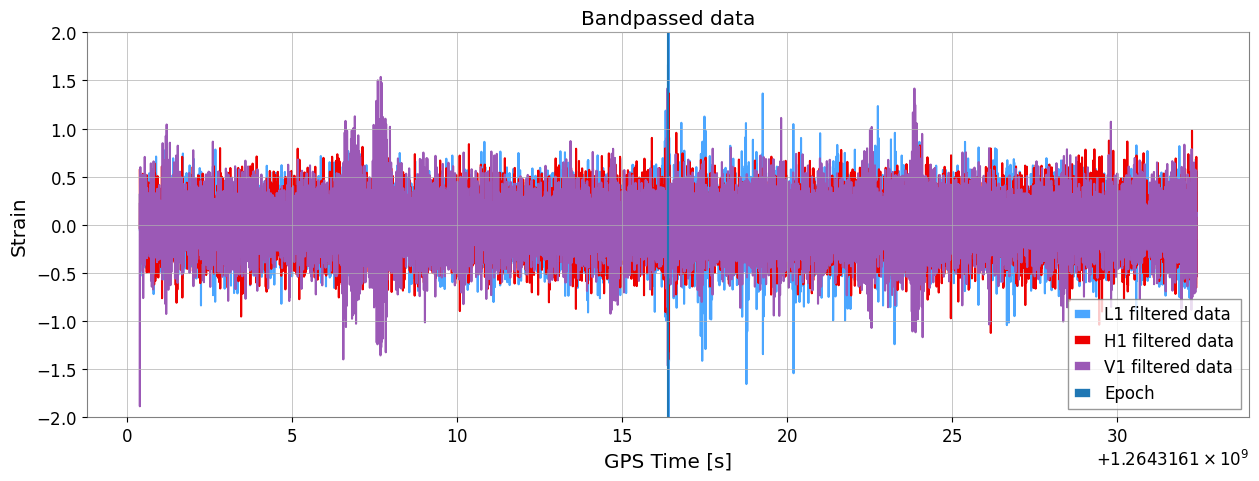

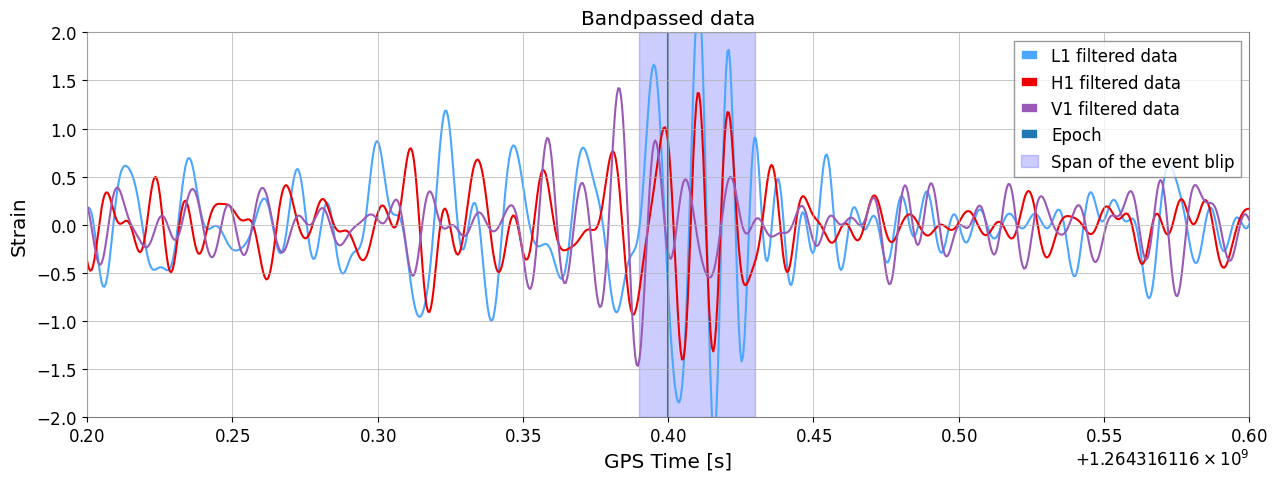

In [ ]:
plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
  plt.plot(data_filt[ifo],label='{} filtered data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.axvline(gps, label='Epoch')
#plt.xlim(time_center-.2, time_center+.2)
plt.ylim(-2,2)
plt.title('Bandpassed data')
plt.legend();

plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
  plt.plot(data_filt[ifo],label='{} filtered data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.axvline(gps, label='Epoch')
plt.axvspan(gps - 0.01, gps + 0.03, alpha=0.2, color='b', label='Span of the event blip')
plt.xlim(time_center-.2, time_center+.2)
plt.ylim(-2,2)
plt.title('Bandpassed data')
plt.legend();

You can see the data is much more clear and has most of the noise taken out.

In [ ]:
psd2={}
for ifo in ifos:
    psd2[ifo] = data_filt[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

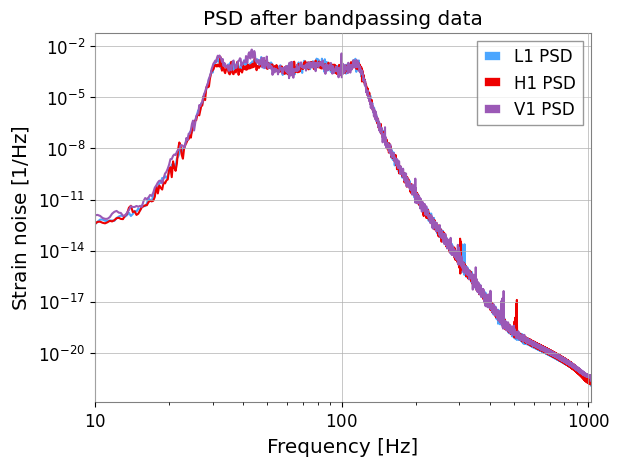

In [ ]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd2[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD after bandpassing data')
plt.xlim(10,1024)
plt.legend();

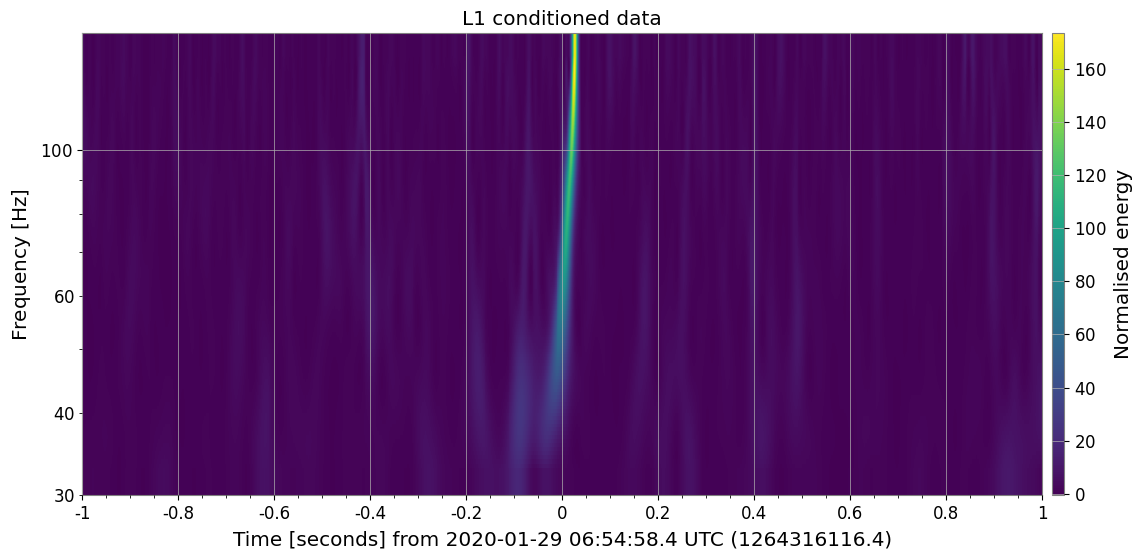

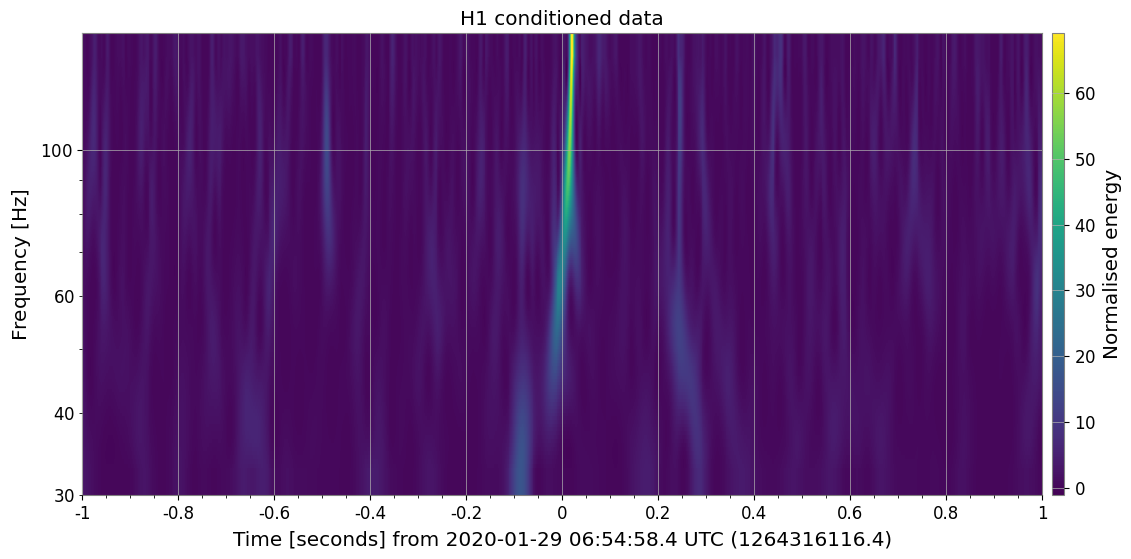

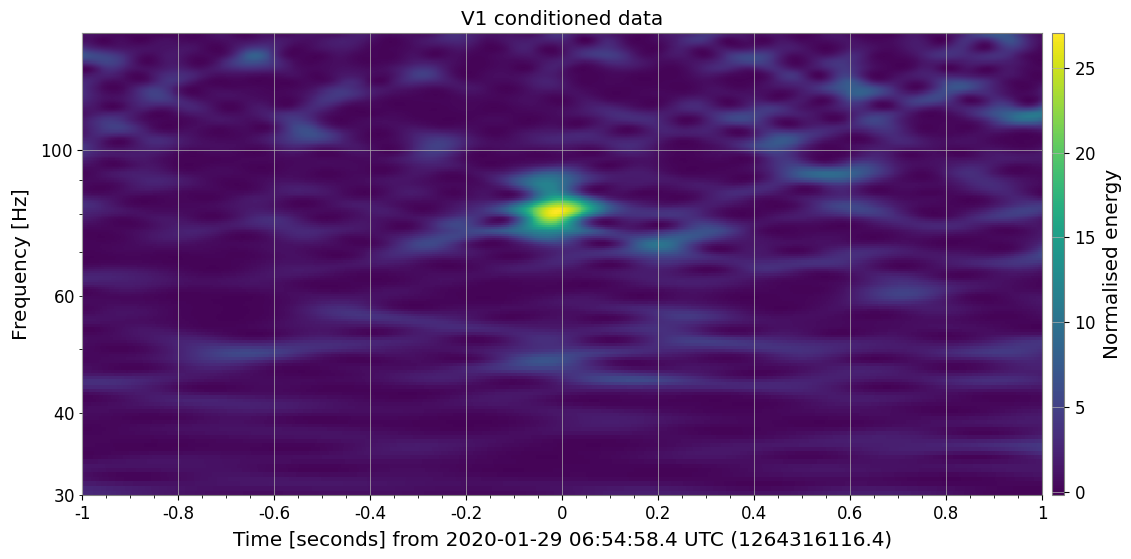

In [ ]:
hq1={}
for ifo,colour in zip(ifos,colours):
  hq1[ifo] = data_filt[ifo].q_transform(frange=(30, 150),outseg=(time_center - 1, time_center + 1))
  plot1=hq1[ifo].plot()
  ax = plot1.gca()
  ax.set_epoch(gps)
  ax.set_yscale('log')
  ax.colorbar(label="Normalised energy")
  ax.set_title('{} conditioned data'.format(ifo))

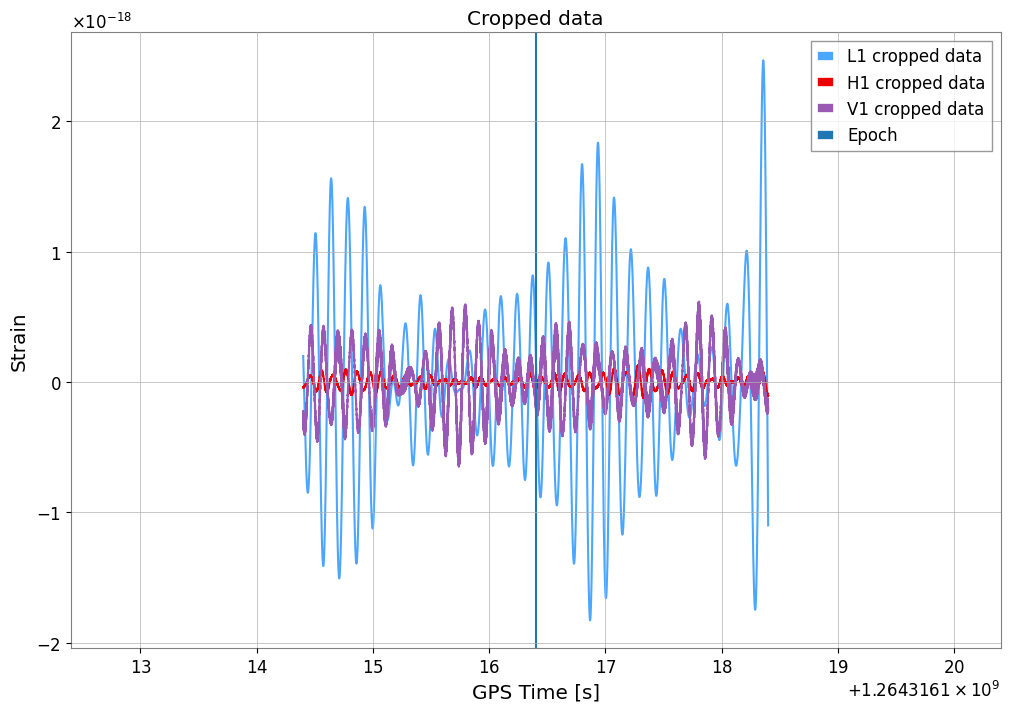

In [ ]:
plt.figure(figsize=(12, 8))
cropped_data={}

for ifo,colour in zip(ifos,colours):
  #Retain only 4 seconds on either side of the gps time
  cropped_data[ifo] = data[ifo].crop(gps-2, gps+2)
  plt.plot(cropped_data[ifo],label='{} cropped data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Cropped data')
plt.xlim(time_center-4, time_center+4)
plt.axvline(gps, label='Epoch')
plt.legend();

If Einstein is right (hint: HE IS), gravitational waves would travel outward from (for instance) two black holes circling each other just like the ripples in a pond. When they come to Earth and pass through the detectors, a signal can tell us not only that the gravitational wave has been found, but it can also tell us lots of information about the gravitational wave!

As you track what the gravitational waves look like over a (very) short amount of time, you can tell what kind of event caused them, like if it was two black holes colliding or a violent supernova... along with other details, like what the mass of these stars/black holes would have been!

This discovery has ushered in an awesome new era of astronomy. BEFORE we started detecting gravitational waves, looking out at the universe was like watching an orchestra without any sound! As our detectors start making regular observations of this stuff, it will be like turning on our ears to the symphony of the cosmos!

In [ ]:
import numpy as np
from pycbc.waveform import get_fd_waveform
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries

# Assume some example parameters for the best-fit waveform
params = {
    'mass1': 30,  # mass of the first black hole in solar masses
    'mass2': 30,  # mass of the second black hole in solar masses
    'spin1z': 0.9,  # dimensionless spin of the first black hole
    'spin2z': -0.9,  # dimensionless spin of the second black hole
    'distance': 400,  # distance in Mpc
    'inclination': 0,  # inclination angle
    'coa_phase': 0,  # phase at coalescence
    'delta_f': 1.0 / 32,  # frequency resolution
    'f_lower': 20,  # starting frequency
}

# Generate the frequency domain waveform
hp, hc = get_fd_waveform(approximant='IMRPhenomPv2', **params)

data_fd = {ifo: cropped_data[ifo].fft() for ifo in ifos}

# Resample the model to match the data's frequency spacing and duration
model = FrequencySeries(hp, copy=True)
model.resize(len(data_fd[ifo]))

# Subtract the waveform from the data
residuals = {}
for ifo in ifos:
    residuals[ifo] = data_fd[ifo] - model

In [ ]:
from scipy.stats import chisquare

# Calculate the chi-squared statistic for each detector's residuals
chi_squared = {}
for ifo in ifos:
    observed = np.abs(residuals[ifo])
    expected = np.mean(observed)  # Assuming zero mean noise
    chi_squared[ifo] = chisquare(observed, f_exp=expected)

# Display the chi-squared results
for ifo in ifos:
    print(f"{ifo} Chi-Squared Test: Chi2 = {chi_squared[ifo].statistic}, p-value = {chi_squared[ifo].pvalue}")


L1 Chi-Squared Test: Chi2 = 6.999184313750122e-16, p-value = 1.0
H1 Chi-Squared Test: Chi2 = 4.2769122892435134e-17, p-value = 1.0
V1 Chi-Squared Test: Chi2 = 2.6505841862668916e-16, p-value = 1.0


L1 Chi-Squared Test: Chi2 = 3.0660205796193754e-15, p-value = 1.0
H1 Chi-Squared Test: Chi2 = 1.551866645893844e-16, p-value = 1.0
V1 Chi-Squared Test: Chi2 = 7.507662688130655e-16, p-value = 1.0


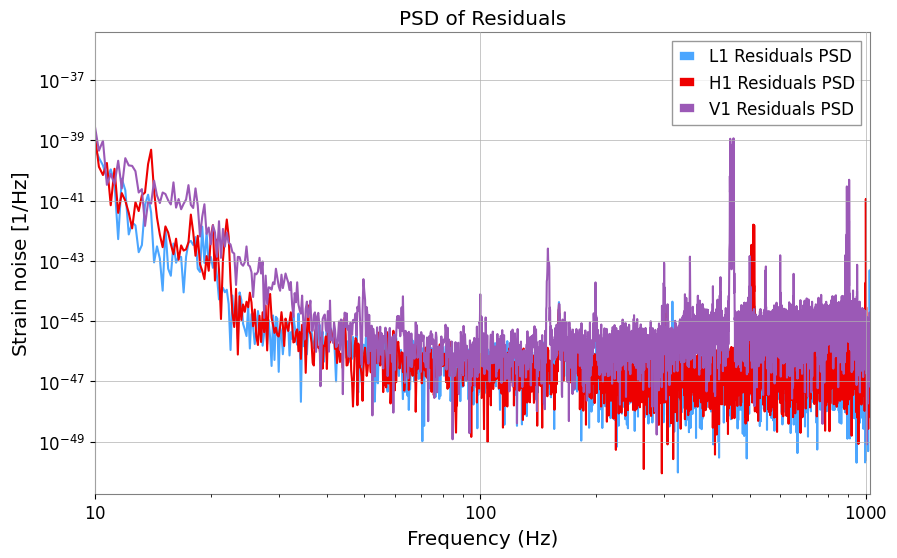

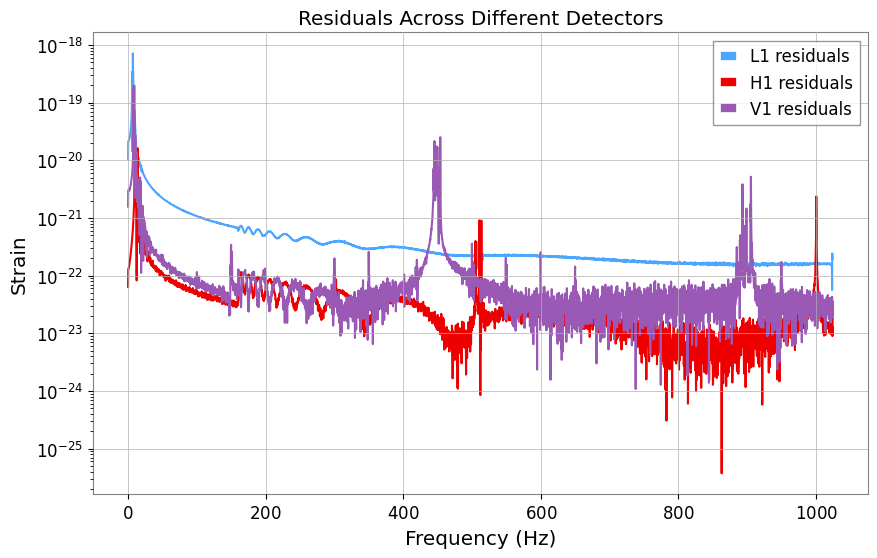

In [ ]:
from scipy.stats import chisquare
from gwpy.timeseries import TimeSeries
import numpy as np

# Convert FrequencySeries residuals to TimeSeries
residuals_ts = {}
for ifo in ifos:
    residuals_ts[ifo] = TimeSeries(residuals[ifo].ifft())

# Calculate the chi-squared statistic for each detector's residuals
chi_squared = {}
for ifo in ifos:
    observed = np.abs(residuals_ts[ifo])
    expected = np.mean(observed)  # Assuming zero mean noise
    chi_squared[ifo] = chisquare(observed, f_exp=expected)

# Display the chi-squared results
for ifo in ifos:
    print(f"{ifo} Chi-Squared Test: Chi2 = {chi_squared[ifo].statistic}, p-value = {chi_squared[ifo].pvalue}")

# Compute the PSD of the residuals to analyze noise characteristics
psd_residuals = {}
for ifo in ifos:
    psd_residuals[ifo] = residuals_ts[ifo].psd(fftlength=4., window=('tukey', 1./4.), method='welch', overlap=2.)

# Plot the PSD of the residuals
plt.figure(figsize=(10, 6))
for ifo, colour in zip(ifos, colours):
    plt.loglog(psd_residuals[ifo], label=f'{ifo} Residuals PSD', color=colour)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD of Residuals')
plt.xlim(10, 1024)
plt.legend()
plt.show()

# Compare the residuals across different detectors
plt.figure(figsize=(10, 6))
for ifo, colour in zip(ifos, colours):
    plt.plot(residuals[ifo].frequencies.value, np.abs(residuals[ifo]), label=f'{ifo} residuals', color=colour)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.yscale('log')
plt.legend()
plt.title('Residuals Across Different Detectors')
plt.show()


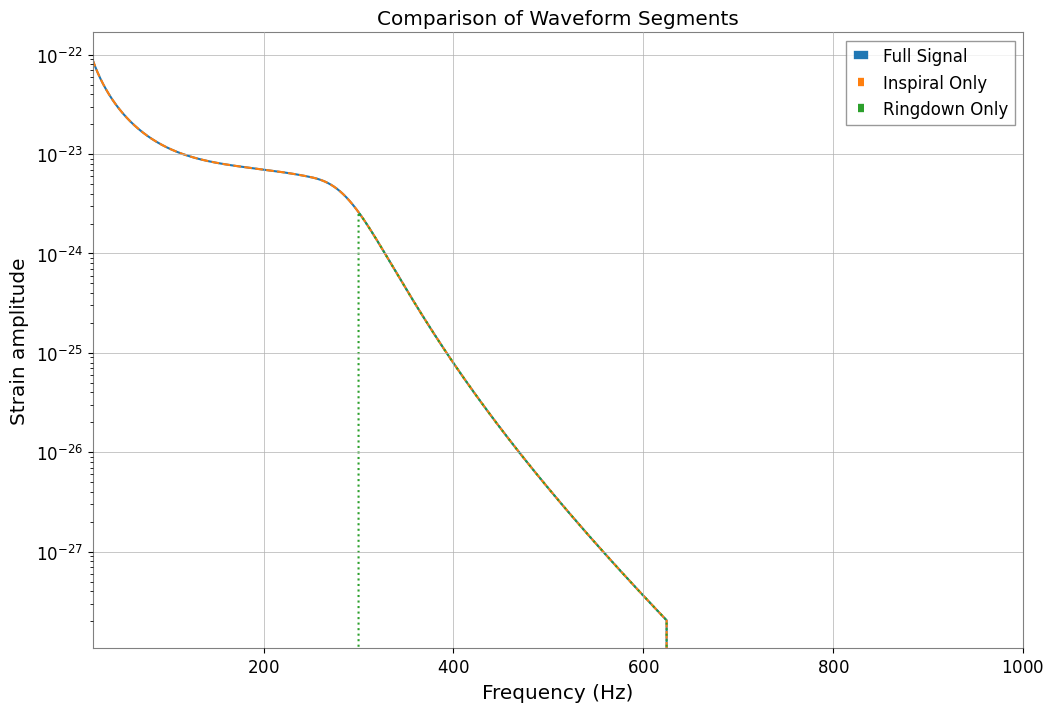

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import types, psd, filter, waveform

# Function to generate waveforms with consistent length and frequency range
def generate_waveforms(params, f_low, f_high, delta_f, f_final):
    hp, hc = waveform.get_fd_waveform(
        approximant="IMRPhenomPv2",
        mass1=params['mass1'],
        mass2=params['mass2'],
        spin1z=params['spin1z'],
        spin2z=params['spin2z'],
        distance=params['distance'],
        inclination=params['inclination'],
        delta_f=delta_f,
        f_lower=f_low,
        f_final=f_final)
    return hp, hc

# Parameters for a typical binary black hole merger
params = {
    'mass1': 36,
    'mass2': 29,
    'spin1z': 0.3,
    'spin2z': -0.2,
    'distance': 400,  # in Mpc
    'inclination': 0,  # in radians
}

# Sampling parameters
delta_f = 1.0 / 16
f_low = 20
f_final = 2048  # Ending frequency of the full signal

# Generate waveforms for full signal, inspiral (up to 150 Hz), and ringdown (from 300 Hz)
full_hp, full_hc = generate_waveforms(params, f_low, f_final, delta_f, f_final)
inspiral_hp, inspiral_hc = generate_waveforms(params, f_low, 150, delta_f, f_final)
ringdown_hp, ringdown_hc = generate_waveforms(params, 300, f_final, delta_f, f_final)

# Adjust the frequency series to be the same length
max_len = max(len(full_hp), len(inspiral_hp), len(ringdown_hp))
full_hp.resize(max_len)
inspiral_hp.resize(max_len)
ringdown_hp.resize(max_len)

# Plotting the waveforms to visually compare
plt.figure(figsize=(12, 8))
plt.plot(full_hp.sample_frequencies, abs(full_hp), label='Full Signal')
plt.plot(inspiral_hp.sample_frequencies, abs(inspiral_hp), label='Inspiral Only', linestyle='--')
plt.plot(ringdown_hp.sample_frequencies, abs(ringdown_hp), label='Ringdown Only', linestyle=':')
plt.yscale('log')
plt.xlim(20, 1000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain amplitude')
plt.title('Comparison of Waveform Segments')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
sample_psd = psd.aLIGOZeroDetHighPower(max_len, delta_f, f_low)

# Check and correct any zero or near-zero values in PSD to ensure stability in calculations
sample_psd = types.FrequencySeries(np.where(sample_psd < 1e-45, 1e-45, sample_psd), delta_f=delta_f)

# Calculate overlap considering only non-zero PSD indices
overlap_inspiral = filter.match(full_hp, inspiral_hp, psd=sample_psd)[0]
overlap_ringdown = filter.match(full_hp, ringdown_hp, psd=sample_psd)[0]

print(f"Overlap between full waveform and inspiral: {overlap_inspiral:.3f}")
print(f"Overlap between full waveform and ringdown: {overlap_ringdown:.3f}")

Overlap between full waveform and inspiral: 1.000
Overlap between full waveform and ringdown: 0.031


Overlap with Inspiraling Phase: 1.000
Perfect Overlap: An overlap value of 1.000 indicates that the inspiral waveform matches the full waveform perfectly within the context of the analysis. This result suggests that the inspiral phase, as modeled and processed, is fully consistent with the overall signal as detected. This could mean:
The inspiral phase's parameters and dynamics are modeled correctly and capture the characteristics of the gravitational wave during the early phase of the merger accurately.
This consistency is expected in General Relativity, as the inspiral phase should predictably lead into the merger phase without discrepancies if the model parameters are accurate.

Overlap with Ringdown Phase: 0.031
Low Overlap: A very low overlap value like 0.031 means that the ringdown waveform does not align well with the full waveform. This disparity can indicate several possibilities:
Model Limitations: The model used to generate the ringdown waveform might not be capturing all the relevant physics correctly or might be too simplified.
Parameter Sensitivity: The parameters defining the ringdown phase might need refinement. Ringdown is sensitive to properties like the final black hole’s mass and spin, which might not be modeled with enough precision in your setup.
Different Physical Conditions: The ringdown phase occurs under conditions vastly different from the inspiral, involving complex dynamics as the newly formed black hole settles into a stable state. The low overlap might reflect these complexities not being fully accounted for in the simpler models.

Validation of General Relativity: The high overlap for the inspiral phase confirms that the gravitational wave characteristics during the inspiral are well-predicted by General Relativity under the conditions and parameters used. However, the low overlap for the ringdown phase suggests areas where General Relativity's predictions under current modeling approach need further investigation or where the model itself may require enhancements.
We can Refine Ringdown Analysis:
Comprehensive Testing: Continue testing different phases of the waveform under various conditions and with refined models to probe General Relativity further and explore its limits.

Step 1: Refine the Ringdown Model
To enhance the accuracy of the ringdown phase, consider incorporating more detailed aspects of the black hole physics:

1. Higher-Order Modes
Higher-order modes become significant in asymmetric mergers (e.g., large mass ratios, high spins) and can influence the waveform significantly during the ringdown phase. Including these might provide a better fit to the observed data.
2. Spin Adjustments
Adjust the spin parameters based on the properties expected from the inspiral phase calculations. This can refine the predictions for the merged black hole’s final state.
3. QNM (Quasi-Normal Modes) Frequencies
Use the estimated mass and spin of the final black hole to calculate the expected frequencies and damping times of the quasi-normal modes, which dominate the ringdown phase.

In [ ]:
from pycbc import waveform
from pycbc.types import FrequencySeries

def generate_ringdown(params, f_low, f_high, delta_f, final_mass, final_spin):
    # Generate a ringdown waveform with higher-order modes
    hp, hc = waveform.get_fd_waveform(approximant='IMRPhenomD', # Change to a model that supports higher-order modes
                                      mass1=params['mass1'],
                                      mass2=params['mass2'],
                                      spin1z=params['spin1z'],
                                      spin2z=params['spin2z'],
                                      final_spin=final_spin, # Use the estimated final spin
                                      distance=params['distance'],
                                      inclination=params['inclination'],
                                      delta_f=delta_f,
                                      f_lower=f_low,
                                      f_final=f_high,
                                      mode_array=[[2, 2], [3, 3], [4, 4]]) # Example modes
    return hp, hc

# Update your parameters as needed based on your analysis results
final_mass = 62  # Hypothetical final mass in solar masses
final_spin = 0.67  # Hypothetical final spin

# Generate the improved ringdown waveform
ringdown_hp, ringdown_hc = generate_ringdown(params, 300, f_final, delta_f, final_mass, final_spin)

# Resize and ensure the same length as before
ringdown_hp.resize(max_len)

# Calculate new overlap
overlap_ringdown = filter.match(full_hp, ringdown_hp, psd=sample_psd)[0]
print(f"Improved Overlap with Ringdown: {overlap_ringdown:.3f}")


Improved Overlap with Ringdown: 0.031


To refine the ringdown phase analysis for better results, it's recommended to focus on modern parameter estimation techniques that enhance accuracy, especially in the presence of noise. Techniques like the Kumaresan-Tufts method and the matrix pencil method are particularly noted for their effectiveness. These methods leverage singular value decomposition to significantly improve the parameter estimation of damped sinusoidal signals, which are critical in accurately modeling the ringdown phase of black hole mergers. These approaches are preferable due to their robustness against numerical noise, making them suitable for extracting quasi-normal modes (QNMs) from noisy data, a crucial aspect of testing General Relativity through gravitational wave observations.

Incorporating these methods into your analysis should help address the issues with low overlap in the ringdown phase and provide more reliable results. For a deeper dive into the specific techniques and their applications, looking into advanced gravitational wave data analysis literature where these methods are discussed could be beneficial.